In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

from aeon.distances import euclidean_distance as aeon_ed, dtw_distance as aeon_dtw

from ksfdtw.distance_measures import (
    psdtw_prime_vanilla as psdtw_prime_vanilla,
    psdtw_prime_lb_shen as psdtw_prime_lb_shen,
)

Time series shape: (100,)
First 10 values: [0.         0.12659245 0.25114799 0.37166246 0.48619674 0.59290793
 0.69007901 0.77614646 0.84972543 0.909632  ]


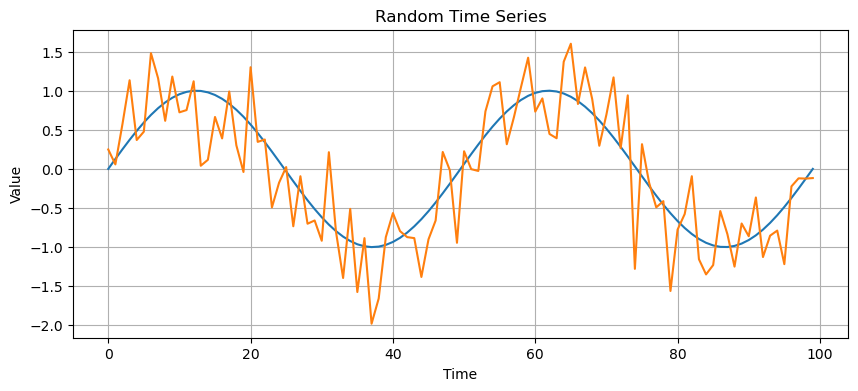

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate a random time series
length = 100  # Number of time points
# time_series = np.random.randn(length)

# Optional: Add a trend or pattern
# time_series = np.random.randn(length) + 0.1 * np.arange(length)  # With trend
Q = np.sin(np.linspace(0, 4 * np.pi, length))
C = np.sin(np.linspace(0, 4 * np.pi, length)) + 0.5 * np.random.randn(
    length
)  # Sinusoidal with noise

print(f"Time series shape: {Q.shape}")
print(f"First 10 values: {Q[:10]}")

# Plot the time series
plt.figure(figsize=(10, 4))
plt.plot(Q)
plt.plot(C)
plt.title("Random Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()

---

In [3]:
@njit
def euclidean_distance(x, y):
    """
    Calculate Euclidean distance between two sequences using numba.

    Parameters:
    x, y: array-like sequences of the same length

    Returns:
    float: Euclidean distance
    """
    if len(x) != len(y):
        raise ValueError("Sequences must have the same length")

    distance = 0.0
    for i in range(len(x)):
        distance += (x[i] - y[i]) ** 2

    return distance

In [4]:
euclidean_distance(Q, C), aeon_ed(Q, C)

(20.682657346718496, 4.547818965913057)

In [5]:
%%timeit
euclidean_distance(Q, C)

269 ns ± 2.34 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [6]:
%%timeit
aeon_ed(Q, C)

209 ns ± 1.51 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [7]:
@njit
def dtw(Q, C, window=None):
    m, n = len(Q), len(C)

    # Convert fractional window to absolute value
    if window is None:
        r = max(m, n)  # No constraint if window is None
    else:
        r = int(window * max(m, n))  # Convert fraction to absolute value

    if abs(n - m) > r:
        raise ValueError("abs(n-m) > r!")

    D = np.full((n + 1, m + 1), np.inf)
    D[0, 0] = 0.0
    for i in range(1, m + 1):
        for j in range(max(1, i - r), min(n, i + r) + 1):
            cost = (Q[i - 1] - C[j - 1]) ** 2
            D[i, j] = cost + min(D[i - 1, j], D[i, j - 1], D[i - 1, j - 1])
    return D[m, n]

In [8]:
dtw(Q, C, window=0.1), aeon_dtw(Q, C, window=0.1)

(16.02946804696052, 16.02946804696052)

In [9]:
%%time
# %%timeit
dtw(Q, C, window=0.1)

CPU times: user 22 μs, sys: 0 ns, total: 22 μs
Wall time: 24.1 μs


16.02946804696052

In [10]:
%%time
# %%timeit
aeon_dtw(Q, C, window=0.1)

CPU times: user 30 μs, sys: 4 μs, total: 34 μs
Wall time: 48.2 μs


16.02946804696052

In [11]:
# %time
import time

start_time = time.time()
dtw(Q, C, window=0.1)
end_time = time.time()
print(f"Execution time: {end_time - start_time:.6f} seconds")
start_time = time.time()
aeon_dtw(Q, C, window=0.1)
end_time = time.time()
print(f"Execution time: {end_time - start_time:.6f} seconds")

Execution time: 0.000049 seconds
Execution time: 0.000057 seconds


---

In [17]:
import time

start_time = time.time()
print(psdtw_prime_vanilla(Q, C, 1.5, 3, 0.1, 0))
end_time = time.time()
print(f"Execution time: {end_time - start_time:.6f} seconds")

(22.075012734967437, 45245, array([[  0,  35,   0,  34],
       [ 35,  67,  34,  68],
       [ 67, 100,  68, 100]]))
Execution time: 0.011893 seconds


In [21]:
start_time = time.time()
print(psdtw_prime_lb_shen(Q, C, 1.5, 3, 0.1, 0))
end_time = time.time()
print(f"Execution time: {end_time - start_time:.6f} seconds")

(22.075012734967437, 43213, array([[  0,  35,   0,  34],
       [ 35,  67,  34,  68],
       [ 67, 100,  68, 100]]))
Execution time: 0.011804 seconds


In [14]:
# for i in range(0, 1):
#     for j in range(0, 50):
#         print(j)
#         if np.isclose(
#             psdtw_prime_vanilla(query_set[i], target_set[j], 2, 3, 0.1, 1)[0],
#             psdtw_prime_lb_shen(query_set[i], target_set[j], 2, 3, 0.1, 1)[0],
#         ):
#             continue
#         else:
#             print(f"Values differ at i={i}, j={j}")
# Values differ at i=0, j=3